# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import ranksums, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower
import statsmodels.stats.multicomp as mc

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import json

In [2]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

In [3]:
batch_corrected = False
zero_remove = False
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()
data_col_idx = 19 if batch_corrected else 16

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(zero_remove)+'_'+str(scaler_term)

In [30]:
with open(os.path.join('results','significant_metabolites_pls2_unique_treatment'+test_enc_name+'.txt'),'r') as f:
    metabolite_names = f.read().splitlines()
print(metabolite_names)
print(len(metabolite_names))

['Aspartic acid', 'Hydroxyproline', 'Guanine.1', 'L-Glutarylcarnitine', 'Deoxyguanosine.2', 'Fructose-1,6-diphosphate', 'L-Asparagine.1', '2-Deoxycytide', 'L-Alanine.1', 'L-Palmitoylcarnitine (C16).1', 'Xanthine.1', 'Sarcosine.1', '2-Hydroxybutyrate.1', 'Thymidine.1', 'Myristoylcarnitine (C14).1', 'Aminoisobutyric acid (BAIBA).1', 'sn-glycerol-3-phosphate.1', 'L-Carnitine (C0)', '2-Aminoadipic acid/Indole-3-carboxylic acid', '3-Hydroxykynurenine.1', 'L-Glutamine.1', 'Citrulline.1', 'Deoxyinosine.1', 'Allantoin.1', 'Normetanephrine-H2O.1', 'ADP.1', 'Cystathionine.1', 'Lipoic Acid.1', 'acetyl-CoA_pos', 'Symmetric Dimethylarginine.1', '1 or 3-Methyl-Histidine.1', 'Threonine.1', 'N-Acetyl-aspartyl-glutamate.1', 'Hypoxanthine.1', 'Argininosuccinic acid.1', 'Isocitric_Citric_acid.1', 'Deoxyadenosine.1', 'Cyclic-AMP.1', '3-Hydroxyisovaleryl Carnitine', 'ATP.2', 'B-Alanine.1', 'Acetylcholine.1', 'Deoxyguanosine.1', '5-Aminovaleric Acid.1', 'Anthranilate.1/2-Aminobenzoic acid/p-Aminobenzoic aci

In [5]:
sns.set(style = 'whitegrid')

# Load data

In [6]:
data_tmp = pd.read_excel(os.path.join(data_path,'2022_12_Laezza_Bernabucci_Mouse_Brain_COMBINED_METABOLOMICS.xlsx'))
data_tmp.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight\n(mg),Treatment,Tissue Type,PND,Litter,Metabolite,MRM Transition of each lipid species\n(Parent ion/Fragment ion),Metabolite used as Internal Standard,Retention Time\n(min),Peak Area of Metabolite,Peak Area of Internal Standard,Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Urea.1,61.0 / 44.0,L-Tryptophan.1.IS,1.959026,5.326877e+07,1.792767e+07,0.053059
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Ethanolamine.1,62.1 / 44.1,L-Tryptophan.1.IS,9.962347,1.287801e+07,1.792767e+07,0.012827
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Imidazole.1,69.0 / 42.2,L-Tryptophan.1.IS,2.478150,1.576080e+05,1.792767e+07,0.000157
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Trimethylamine-N-oxide.1,76.0 / 58.1,L-Tryptophan.1.IS,4.874291,1.159692e+07,1.792767e+07,0.011551
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Glycine.2,76.0 / 30.0,L-Tryptophan.1.IS,6.283526,4.631088e+06,1.792767e+07,0.004613


In [7]:
metadata = data_tmp.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, data_tmp.iloc[:,15]],axis=1)
else:
    data = pd.concat([metadata, data_tmp.iloc[:,15]],axis=1)

if zero_remove:
    data_stats = data.reset_index()[data.reset_index().iloc[:,6:] > 1E-5]
else:
    min_value = data.loc[data.loc[data['Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))']>0.0,'Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))'].idxmin(),'Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))']
    data_stats = data.reset_index() 
    data_stats.iloc[:,-1] = data_stats.iloc[:,-1] + 0.1*min_value

data_stats

,index,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight\n(mg),Treatment,Tissue Type,PND,Litter,Metabolite,MRM Transition of each lipid species\n(Parent ion/Fragment ion),Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))
0,0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Urea.1,61.0 / 44.0,5.305928e-02
1,1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Ethanolamine.1,62.1 / 44.1,1.282740e-02
2,2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Imidazole.1,69.0 / 42.2,1.570452e-04
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Trimethylamine-N-oxide.1,76.0 / 58.1,1.155136e-02
4,4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Glycine.2,76.0 / 30.0,4.612928e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,16195,83,11/2022,T36F3S,F,84,deltamethrin,striatum,60,T36,UDP-N-acetyl-glucosamine,606.0 / 385.0,1.422320e-04
16196,16196,83,11/2022,T36F3S,F,84,deltamethrin,striatum,60,T36,NAD,662.2 / 540.1,9.151337e-04
16197,16197,83,11/2022,T36F3S,F,84,deltamethrin,striatum,60,T36,NADH,664.1 / 408.1,2.593402e-04
16198,16198,83,11/2022,T36F3S,F,84,deltamethrin,striatum,60,T36,NADP,742.0 / 620.1,4.350554e-06


In [8]:
data = data_stats.loc[data_stats['Metabolite'].isin(metabolite_names)].copy(deep=True)
data.columns = ['Index','SampleNumber', 'SampleSubmissionDate', 'SampleName', 'Sex', 'Tissue weight\n(mg)', 'Treatment', 'TissueType', 'PND', 'Litter', 'Metabolite', 'MRM Transition of each lipid species\n(Parent ion/Fragment ion)','Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))']
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,Tissue weight\n(mg),Treatment,TissueType,PND,Litter,Metabolite,MRM Transition of each lipid species\n(Parent ion/Fragment ion),Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight))
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Trimethylamine-N-oxide.1,76.0 / 58.1,0.011551
5,5,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Sarcosine.1,90.0 / 44.0,0.000065
6,6,1,09/2021,C20M1S,M,56,control,striatum,30,C20,L-Alanine.1,90.1 / 44.1,0.021020
7,7,1,09/2021,C20M1S,M,56,control,striatum,30,C20,B-Alanine.1,90.1 / 30.1,0.001841
11,11,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Aminoisobutyric acid (BAIBA).1,104.1 / 86.0,0.000661


In [9]:
data['Sex'].value_counts()
data['SampleSubmissionDate'].value_counts()

09/2021    3408
11/2022    1704
Name: SampleSubmissionDate, dtype: int64

In [10]:
data['log_area'] = np.log(data.iloc[:,-1])
data['log_scaled_area'] = scaler.fit_transform(data[['log_area']])
data.head()

,Index,SampleNumber,SampleSubmissionDate,SampleName,Sex,Tissue weight\n(mg),Treatment,TissueType,PND,Litter,Metabolite,MRM Transition of each lipid species\n(Parent ion/Fragment ion),Normalized Peak Area\n(Peak Area of Metabolite / (Peak Area of Internal Standard * Tisue weight)),log_area,log_scaled_area
3,3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Trimethylamine-N-oxide.1,76.0 / 58.1,0.011551,-4.460952,0.704862
5,5,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Sarcosine.1,90.0 / 44.0,0.000065,-9.644788,0.405752
6,6,1,09/2021,C20M1S,M,56,control,striatum,30,C20,L-Alanine.1,90.1 / 44.1,0.021020,-3.862264,0.739407
7,7,1,09/2021,C20M1S,M,56,control,striatum,30,C20,B-Alanine.1,90.1 / 30.1,0.001841,-6.297481,0.598893
11,11,1,09/2021,C20M1S,M,56,control,striatum,30,C20,Aminoisobutyric acid (BAIBA).1,104.1 / 86.0,0.000661,-7.322265,0.539763


# Manipulate data

Add a column to identify the date

In [11]:
def classify_date(input_date):
    if input_date == '09/2021':
        return 1
    else:
        return 2

data['dateId'] = data['SampleSubmissionDate'].apply(lambda x: classify_date(x))

In [12]:
# df_sub = data[(data['TissueType'] == 'cortex') & (data['PND'] == 30)].copy()
df_sub = data.copy()
df_sub['class'] = [0 if x == 'control' else 1 for x in df_sub['Treatment']]

df_pivot = df_sub.pivot_table(index='Metabolite', columns='SampleNumber',values='log_scaled_area',dropna=True).T


class_values = df_sub.groupby('SampleNumber').mean()['class']

print(df_pivot.columns)


Index(['1 or 3-Methyl-Histidine.1',
       '2-Aminoadipic acid/Indole-3-carboxylic acid', '2-Deoxycytide',
       '2-Hydroxybutyrate.1', '2-Octenoylcarnitine',
       '2/3-Phosphoglyceric acid.2', '3-Hydroxyisovaleryl Carnitine',
       '3-Hydroxykynurenine.1', '5-Aminovaleric Acid.1', 'ADP.1', 'ATP.2',
       'Acetylcholine.1', 'Allantoin.1', 'Aminoisobutyric acid (BAIBA).1',
       'Anthranilate.1/2-Aminobenzoic acid/p-Aminobenzoic acid',
       'Argininosuccinic acid.1', 'Ascorbic acid.1', 'Aspartic acid',
       'B-Alanine.1', 'CMP.1', 'Citrulline.1', 'Cyclic-AMP.1',
       'Cystathionine.1', 'Deoxyadenosine.1', 'Deoxyguanosine.1',
       'Deoxyguanosine.2', 'Deoxyinosine.1', 'Dopamine.1',
       'Fructose-1,6-diphosphate', 'G6P.1', 'GTP.1', 'Glutathione.1',
       'Glycerophosphocholine.1', 'Guanine.1', 'Guanosine.1',
       'Hippuric acid.1', 'Homoarginine.1', 'Hydroxyproline', 'Hypoxanthine.1',
       'IMP.1', 'Inosine.1', 'Isocitric_Citric_acid.1',
       'L-Acetylcarnitine (C2

# Figures

In [13]:
data.shape

(5112, 16)

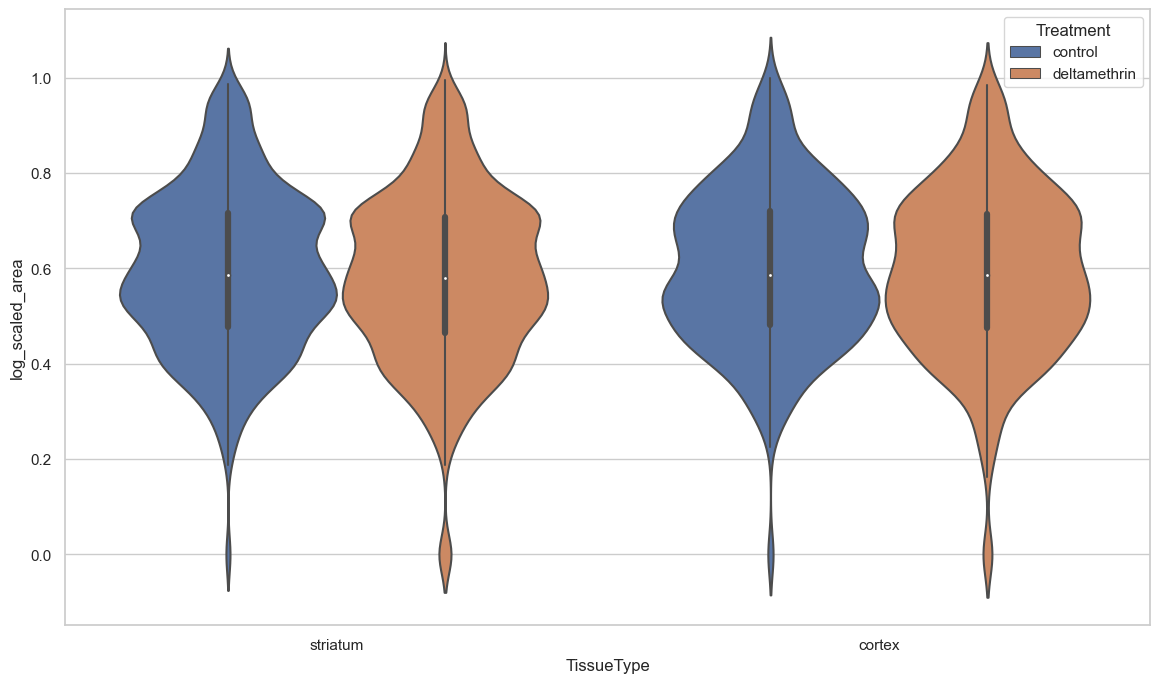

In [16]:
fig100 = plt.figure(figsize=(14,8))
ax = sns.violinplot(data=data, x='TissueType', hue='Treatment', y='log_scaled_area')
ax.set_xlabel('TissueType')

fig100.savefig(os.path.join(data_path,"violinplot-tissue.svg"), format='svg', facecolor='w')

plt.show()

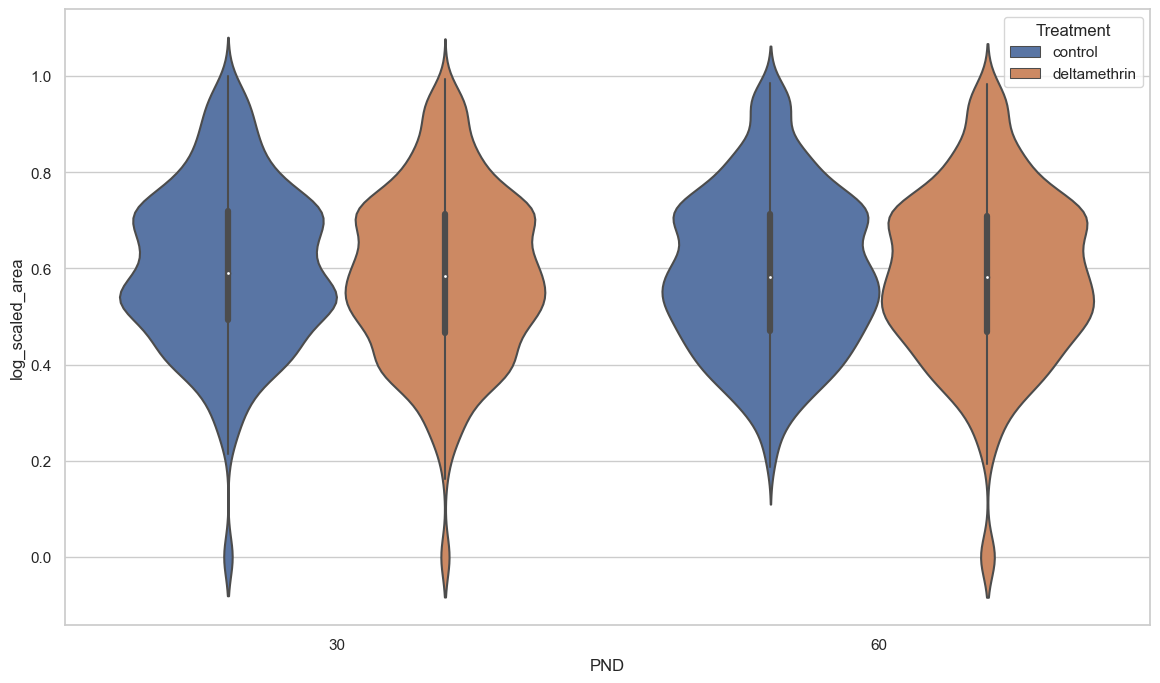

In [15]:
fig = plt.figure(figsize=(14,8))
ax = sns.violinplot(data=data, x='PND', hue='Treatment', y='log_scaled_area')
ax.set_xlabel('PND')
                    
fig.savefig(os.path.join(data_path,"violinplot-pnd.svg"), format='svg', facecolor='w')

plt.show()

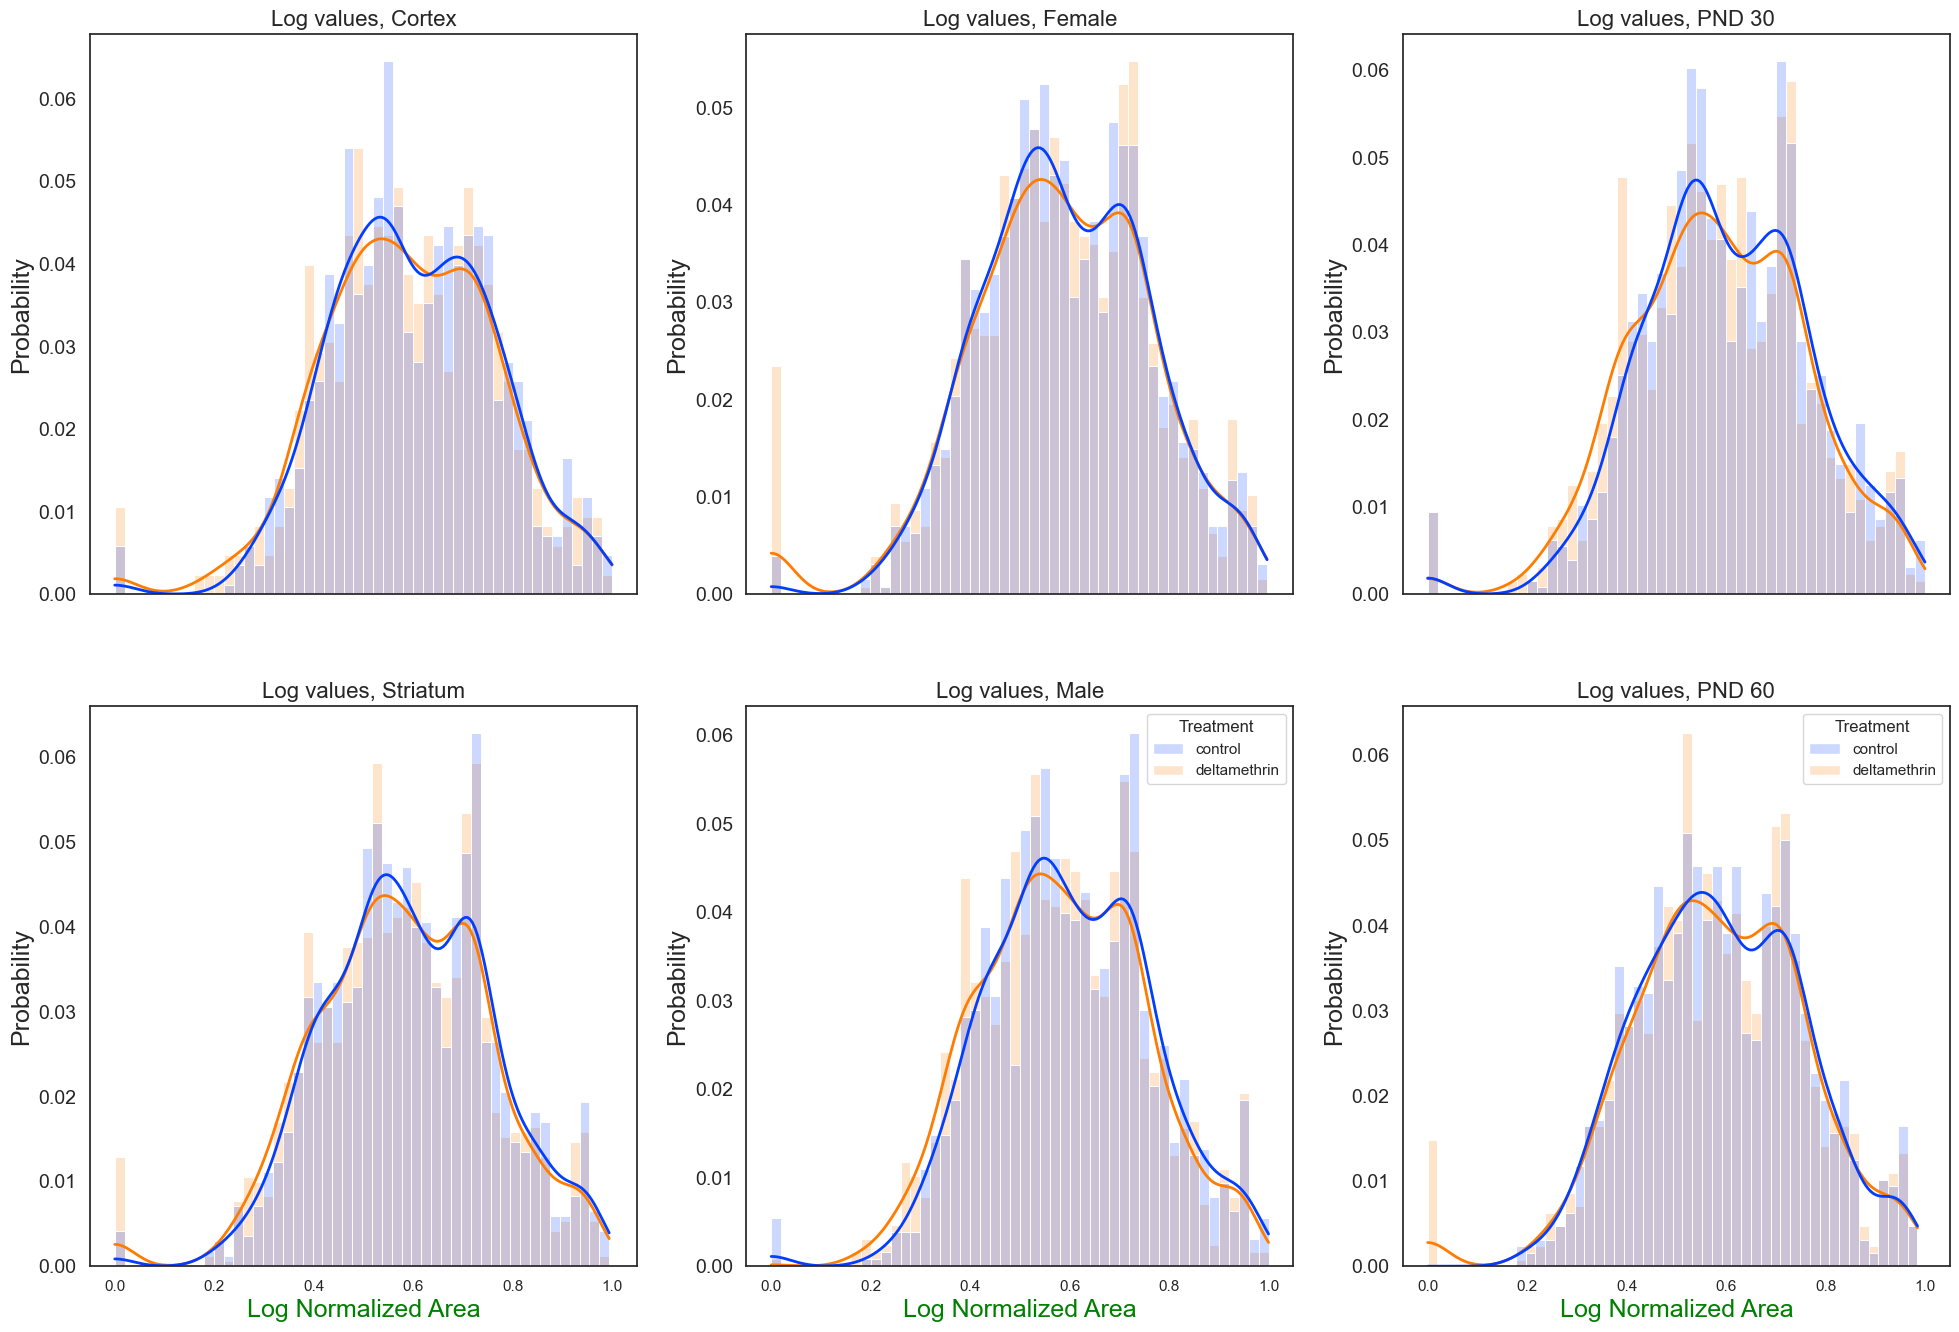

In [17]:
sns.set_style('white')

fig, ax = plt.subplots(2, 3, sharex=True, figsize=(24,16), )

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[data['TissueType'] == 'cortex'], x='log_scaled_area', hue='Treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Cortex', fontsize=16)
ax[0,0].set_ylabel('Probability', fontsize=18)
ax[0,0].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['TissueType'] == 'striatum'], x='log_scaled_area', hue='Treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum', fontsize=16)
ax[1,0].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,0].set_ylabel('Probability', fontsize=18)
ax[1,0].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['Sex'] == 'F'], x='log_scaled_area', hue='Treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Female', fontsize=16)
ax[0,1].set_ylabel('Probability', fontsize=18)
ax[0,1].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['Sex'] == 'M'], x='log_scaled_area', hue='Treatment', ax=ax[1,1], legend=True, **opt)
ax[1,1].set_title('Log values, Male', fontsize=16)
ax[1,1].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,1].set_ylabel('Probability', fontsize=18)
ax[1,1].tick_params(axis='y', labelsize=14)

sns.histplot(data=data[data['PND'] == 30], x='log_scaled_area', hue='Treatment', ax=ax[0,2], legend=False, **opt)
ax[0,2].set_title('Log values, PND 30', fontsize=16)
ax[0,2].set_ylabel('Probability', fontsize=18)
ax[0,2].tick_params(axis='y', labelsize=14)
sns.histplot(data=data[data['PND'] == 60], x='log_scaled_area', hue='Treatment', ax=ax[1,2], legend=True, **opt)
ax[1,2].set_title('Log values, PND 60', fontsize=16)
ax[1,2].set_xlabel('Log Normalized Area', fontsize=18, color='green')
ax[1,2].set_ylabel('Probability', fontsize=18)
ax[1,2].tick_params(axis='y', labelsize=14)

fig.savefig(os.path.join(data_path,"distribution-3cases.png"), format='png', facecolor='w', dpi=600)

plt.show()

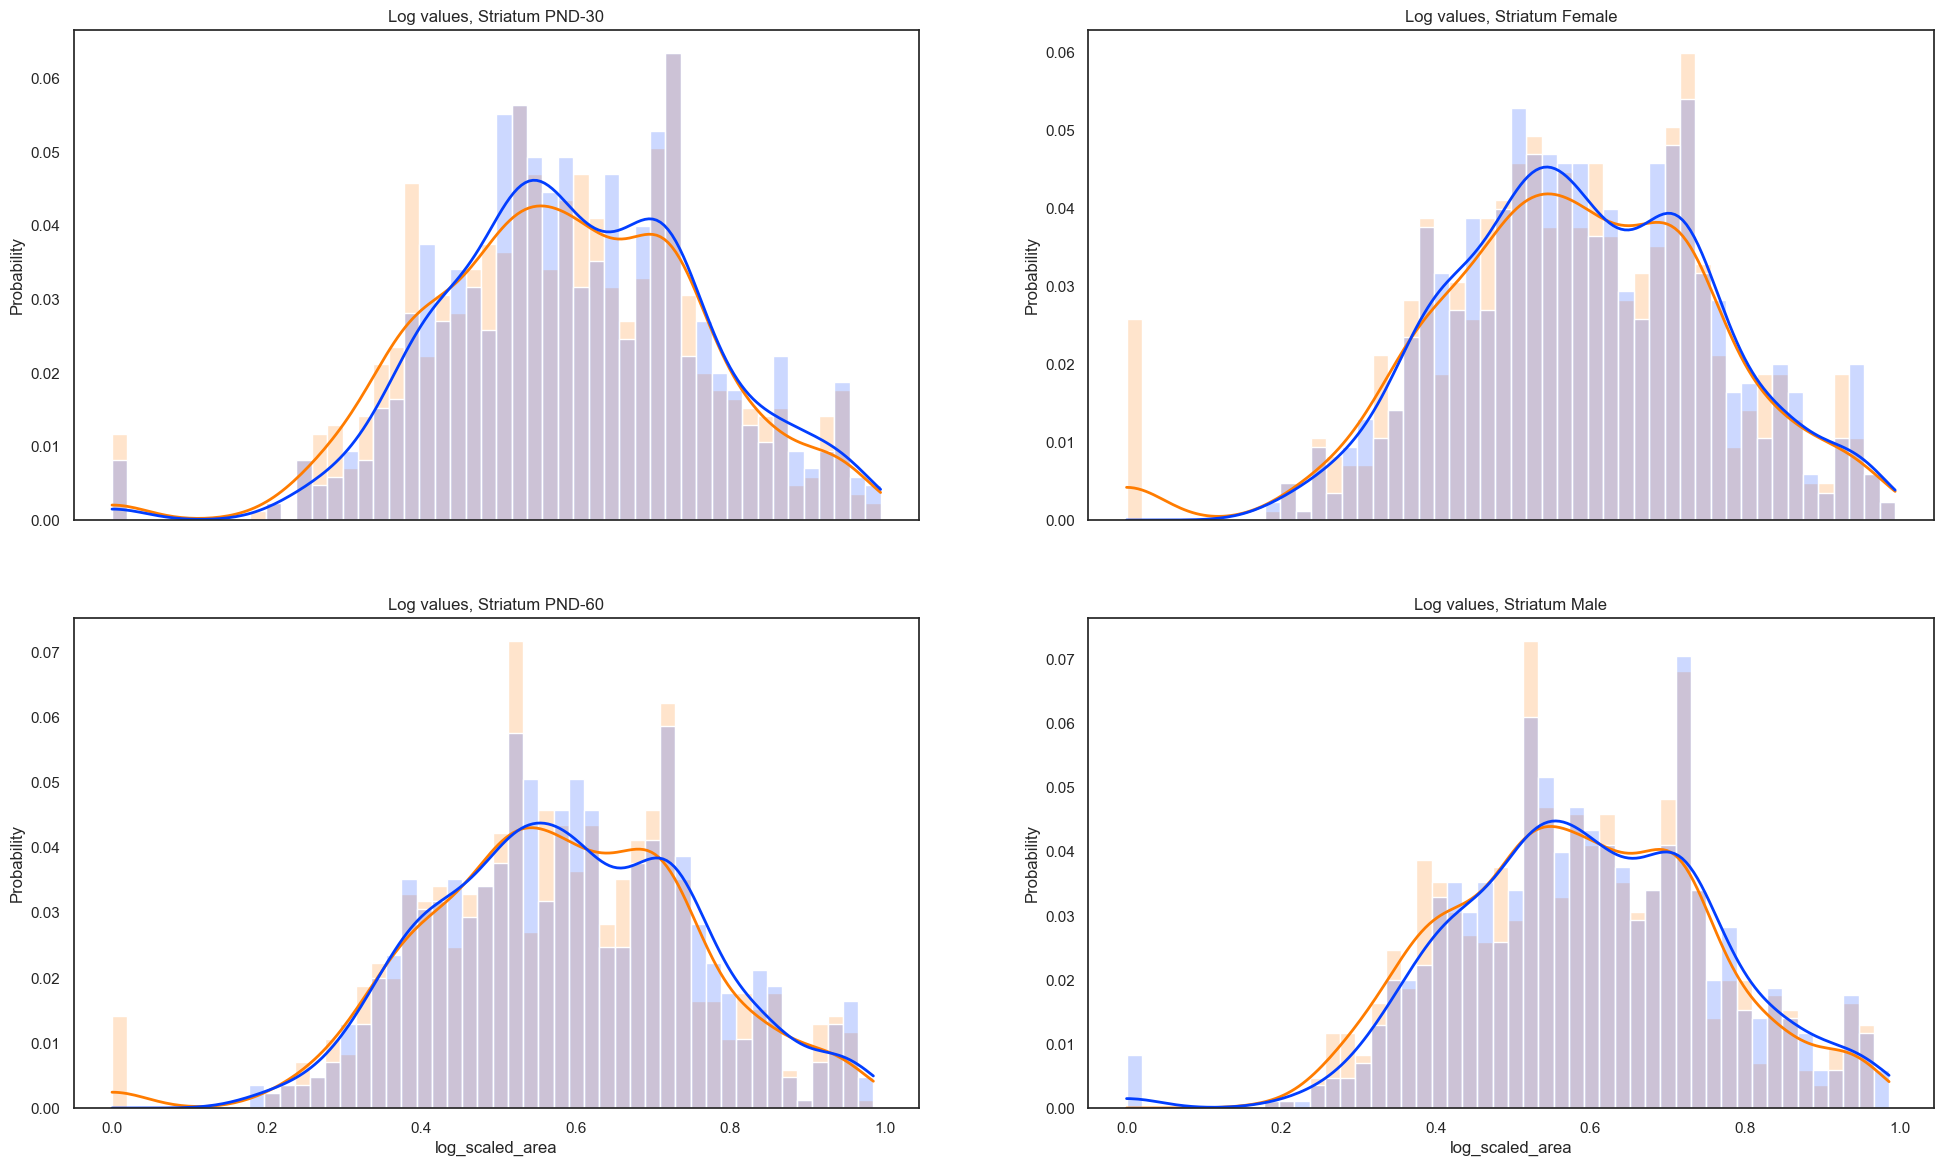

In [18]:
sns.set_style('white')

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(24,14))

opt = {'bins': 50, 'alpha': 0.2, 'palette': 'bright',
        'stat': 'probability', 'kde': True,
        'line_kws': {'lw': 2}, 'common_norm': False}

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 30)], x='log_scaled_area', hue='Treatment', ax=ax[0,0], legend=False, **opt)
ax[0,0].set_title('Log values, Striatum PND-30')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['PND'] == 60)], x='log_scaled_area', hue='Treatment', ax=ax[1,0], legend=False, **opt)
ax[1,0].set_title('Log values, Striatum PND-60')

sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'F')], x='log_scaled_area', hue='Treatment', ax=ax[0,1], legend=False, **opt)
ax[0,1].set_title('Log values, Striatum Female')
sns.histplot(data=data[(data['TissueType'] == 'striatum') & (data['Sex'] == 'M')], x='log_scaled_area', hue='Treatment', ax=ax[1,1], legend=False, **opt)
ax[1,1].set_title('Log values, Striatum Male')

fig.savefig(os.path.join(data_path,"distribution-Striatum-2cases.svg"), format='svg', facecolor='w')

plt.show()

# Statistics

## Wilcoxon test applied on the data with no normalization

#### Data divided by tissue

In [19]:
tissue = ['striatum','cortex']
sex = ['F', 'M']
pnd = [30,60]
var_name = 'log_scaled_area'


for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ranksums(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 5.28e-02
Tissue: cortex. P-value: 3.02e-01


#### Data divided by gender

In [20]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ranksums(a,b).pvalue:.2e}')

Gender: F. P-value: 4.32e-01
Gender: M. P-value: 1.98e-02


#### Data divided by PND

In [21]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 1.04e-02
PND: 60. P-value: 5.98e-01


## T-test applied on the data with log normalization

#### Data divided by tissue

In [22]:
var_name = 'log_scaled_area'

for t in tissue:
    a = data[(data['Treatment'] == 'control') & (data['TissueType']==t)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['TissueType']==t)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Tissue: {t}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Tissue: striatum. P-value: 1.66e-02
Tissue: cortex. P-value: 1.75e-01


#### Data divided by gender

In [23]:
for g in sex:
    a = data[(data['Treatment'] == 'control') & (data['Sex']==g)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['Sex']==g)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'Gender: {g}. P-value: {ttest_ind(a,b).pvalue:.2e}')

Gender: F. P-value: 1.01e-01
Gender: M. P-value: 2.40e-02


#### Data divided by PND

In [24]:
for p in pnd:
    a = data[(data['Treatment'] == 'control') & (data['PND']==p)][var_name]
    b = data[(data['Treatment'] == 'deltamethrin') & (data['PND']==p)][var_name]

    a = a.dropna()
    b = b.dropna()

    print(f'PND: {p}. P-value: {ranksums(a,b).pvalue:.2e}')

PND: 30. P-value: 1.04e-02
PND: 60. P-value: 5.98e-01


## Three-way ANOVA on log normalized data

#### Quelli singoli sono mediati su tutto il resto. Mentre l'effetto del secondo oridne dice che è vero che partono da livelli differenti diversi striato e corteccia, ma l'effetto del trattamento ha effetto anche se loro sono già diversi

In [25]:
model = ols('log_scaled_area ~ C(Sex) + C(Treatment) + C(TissueType) + C(dateId) + C(Sex):C(Treatment) + C(TissueType):C(Treatment) + C(dateId):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.037949,1.0,1.304935,0.253367
C(Treatment),0.218681,1.0,7.519780,0.006124
C(TissueType),0.089251,1.0,3.069058,0.079856
C(dateId),0.003044,1.0,0.104673,0.746306
C(Sex):C(Treatment),0.003379,1.0,0.116209,0.733197
C(TissueType):C(Treatment),0.025997,1.0,0.893965,0.344450
C(dateId):C(Treatment),0.055074,1.0,1.893843,0.168829
Residual,148.428261,5104.0,NaN,NaN


In [54]:
model = ols('log_scaled_area ~ C(Sex) + C(PND) + C(Treatment) + C(TissueType) + C(PND):C(Treatment) + C(Sex):C(Treatment) + C(TissueType):C(Treatment)', data=data).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.037949,1.0,1.305084,0.253340
C(PND),0.041811,1.0,1.437903,0.230535
C(Treatment),0.218681,1.0,7.520639,0.006121
C(TissueType),0.098039,1.0,3.371638,0.066386
C(PND):C(Treatment),0.033256,1.0,1.143714,0.284920
C(Sex):C(Treatment),0.003379,1.0,0.116222,0.733183
C(TissueType):C(Treatment),0.002569,1.0,0.088358,0.766287
Residual,148.411313,5104.0,NaN,NaN


### Anova only striatum

In [55]:
data_striatum = data[data['TissueType'] == 'striatum'].copy(deep=True)

In [56]:
model = ols('log_scaled_area ~ C(Sex) + C(Treatment)  + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.065941,1.0,2.240352,0.134543
C(Treatment),0.168991,1.0,5.741527,0.016622
C(Sex):C(Treatment),0.012582,1.0,0.427464,0.513280
Residual,100.190525,3404.0,NaN,NaN


In [57]:
model = ols('log_scaled_area ~ C(Sex) + C(PND) + C(Treatment)+ C(PND):C(Treatment) + C(Sex):C(Treatment)', data=data_striatum).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(Sex),0.065941,1.0,2.239788,0.134592
C(PND),0.031316,1.0,1.063699,0.302446
C(Treatment),0.168991,1.0,5.740081,0.016636
C(PND):C(Treatment),0.002338,1.0,0.079420,0.778102
C(Sex):C(Treatment),0.012582,1.0,0.427356,0.513333
Residual,100.156871,3402.0,NaN,NaN


# Single lipids statistics

## Define lipids list

In [29]:
metabolites_list = data['Metabolite'].unique()
print(metabolites_list.shape[0])

71


## Test lipid

In [ ]:
data_lipid = data[data['IndividualLipidSpecies'] == lipids_list[0]]

from scipy.stats import ttest_ind
multcomp = mc.MultiComparison(data_lipid['log_scaled_area'], groups=data_lipid['Treatment'])
res = multcomp.allpairtest(ttest_ind)[1][2][0]
print(res)
res = multcomp.allpairtest(ttest_ind)[0]
print(res)

0.2536188557653341
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.05, alphacBonf=0.050
 group1    group2     stat   pval  pval_corr reject
---------------------------------------------------
control deltamethrin 1.1511 0.2536    0.2536  False
---------------------------------------------------


## Analysis control vs treatment

In [31]:
import itertools
factor = 'Treatment'
results_all = []
for m in metabolites_list:
    data_metabolite = data[data['Metabolite'] == m]
    if data_metabolite[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_metabolite[factor].unique(),2):
            a = data_metabolite[data_metabolite[factor] == c[0]]['log_scaled_area'].values
            b = data_metabolite[data_metabolite[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([m, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['metabolite', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

,metabolite,fc,p,Treatment1,Treatment2,effectSize,sampleSize,statisticalPower
0,Trimethylamine-N-oxide.1,1.007816,0.303967,control,deltamethrin,0.247548,36,0.179093
1,Sarcosine.1,1.025497,0.185317,control,deltamethrin,0.319777,36,0.267508
2,L-Alanine.1,1.007538,0.231296,control,deltamethrin,0.288653,36,0.226770
3,B-Alanine.1,1.011136,0.135012,control,deltamethrin,0.361459,36,0.327535
4,Aminoisobutyric acid (BAIBA).1,1.009693,0.265529,control,deltamethrin,0.268304,36,0.202259


### Statistical power with average effectSize

In [ ]:
es_mean = np.median(results_all['effectSize'][results_all['p']<0.05])
# es_mean = 0.8
print(es_mean)
n_mice = 24
statisticalPower = TTestIndPower().power(effect_size=es_mean, nobs1=n_mice, alpha=0.05)
print(statisticalPower)

0.5040398590800018
0.4012709294905219


### Given an effect size, and a statistical power, determine n_mice

In [ ]:
es_mean = 0.7
alpha = 0.05
statisticalPower = 0.8
n_mice_ideal = TTestIndPower().solve_power(effect_size=es_mean, alpha=alpha, power=statisticalPower)
print(n_mice_ideal)

33.02456951586263


## Plots

In [39]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break 

In [50]:
def plot_volcano(results_all, fc_threshold=0.3, pvalue_threshold=1.5):
    
    col = np.where(np.log2(results_all['fc']) < -fc_threshold,'r',np.where(np.log2(results_all['fc']) > fc_threshold,'g','k'))

    fig = plt.figure(figsize=(14,12))
    plt.scatter(np.log2(results_all['fc']), -np.log10(results_all['p']), c=col)
    shownlabels = []
    l_ha = ['right','left']

    for i in range(results_all.shape[0]): 

        x = np.log2(results_all.iloc[i]['fc'])
        y = -np.log10(results_all.iloc[i]['p'])
        aa = np.random.rand()*3 - 1.5 + 0.5 * np.sign(x)
        ii = np.sign(aa) * 0.5 + 0.5
        if (np.abs(x) > fc_threshold) and (y > pvalue_threshold):
            l = plt.text(x+0.01*aa, y, 
                         results_all.iloc[i]['metabolite'],ha=l_ha[int(ii)], va='center', color='k', 
                         fontsize=10, zorder=10,bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
            shownlabels.append(l)

    #adjustlabels(fig, shownlabels)

    plt.xlabel('log FC',)
    plt.ylabel('-log10 (Pvalue)')
    plt.rc('axes', labelsize=18) 

    plt.show()

In [53]:
import itertools
factor = 'Treatment'
results_all = []
for m in metabolites_list:
    data_metabolite = data[data['Metabolite'] == m]
    if data_metabolite[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_metabolite[factor].unique(),2):
            a = data_metabolite[data_metabolite[factor] == c[0]]['log_scaled_area'].values
            b = data_metabolite[data_metabolite[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            cd = np.abs((np.mean(a) - np.mean(b)))
            cd /= np.sqrt(
                ((a.size - 1)*np.var(a) + (b.size - 1)*np.var(b)) / (a.size + b.size - 2)
            )
            n_samples = a.size
            sp = TTestIndPower().power(effect_size=cd, nobs1=n_samples, alpha=0.05)
            results_all.append([m, fc, pvalue, c[0], c[1], cd, n_samples, sp])

colnames = ['metabolite', 'fc', 'p', factor+'1', factor+'2', 'effectSize', 'sampleSize', 'statisticalPower']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

,metabolite,fc,p,Treatment1,Treatment2,effectSize,sampleSize,statisticalPower
0,Trimethylamine-N-oxide.1,1.007816,0.303967,control,deltamethrin,0.247548,36,0.179093
1,Sarcosine.1,1.025497,0.185317,control,deltamethrin,0.319777,36,0.267508
2,L-Alanine.1,1.007538,0.231296,control,deltamethrin,0.288653,36,0.226770
3,B-Alanine.1,1.011136,0.135012,control,deltamethrin,0.361459,36,0.327535
4,Aminoisobutyric acid (BAIBA).1,1.009693,0.265529,control,deltamethrin,0.268304,36,0.202259


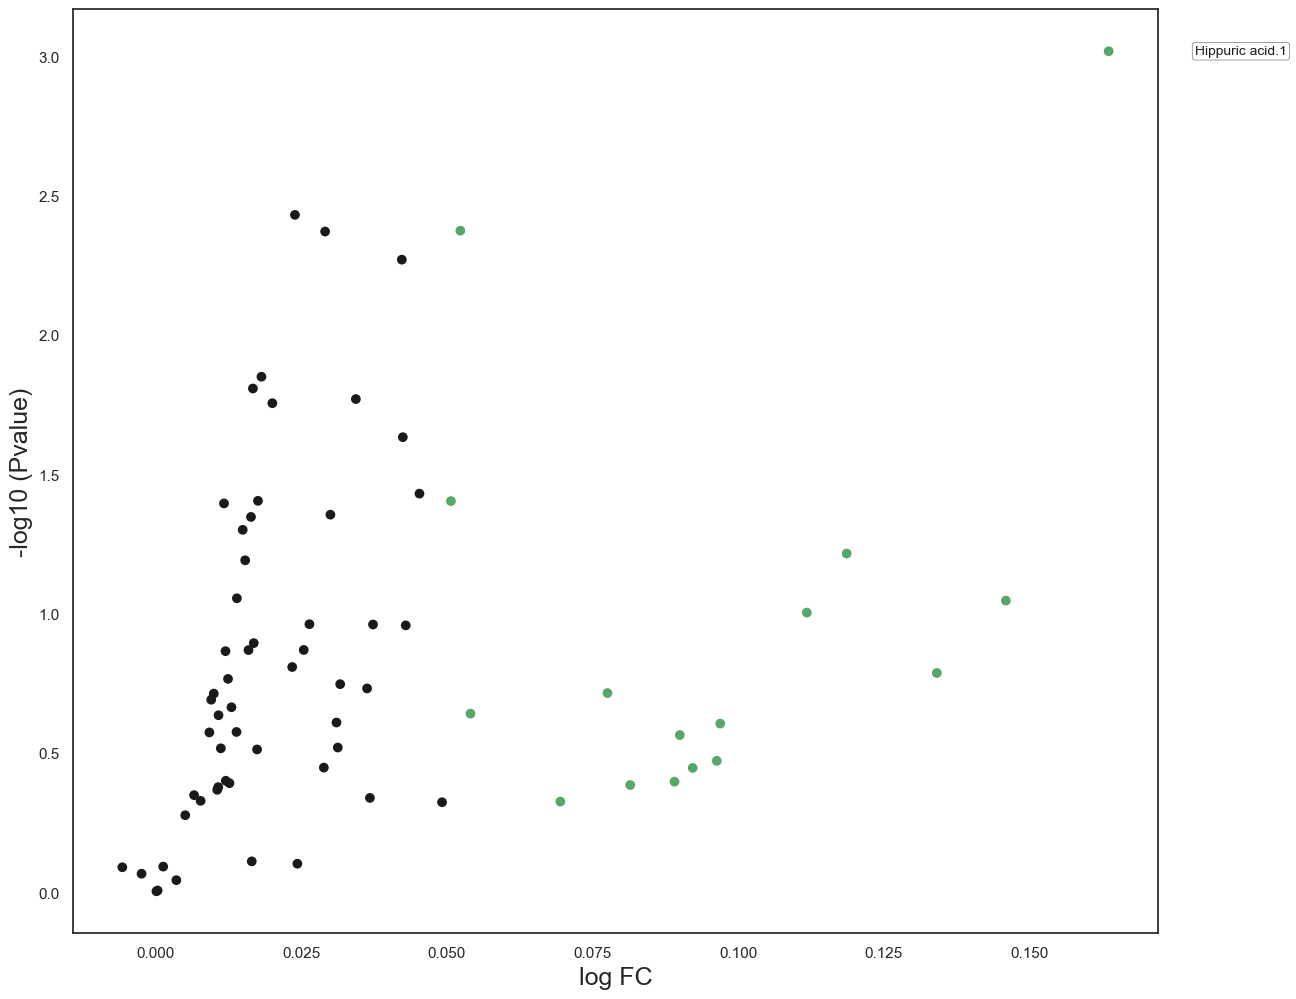

In [54]:
plot_volcano(results_all,fc_threshold=0.05, pvalue_threshold=3)

## Analysis striatum vs cortex

In [55]:
factor = 'TissueType'
results_all = []
for m in metabolites_list:
    data_metabolite = data[data['Metabolite'] == m]
    if data_metabolite[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_metabolite[factor].unique(),2):
            a = data_metabolite[data_metabolite[factor] == c[0]]['log_scaled_area'].values
            b = data_metabolite[data_metabolite[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([m, fc, pvalue, c[0], c[1]])

colnames = ['metabolite', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','tissue_treatment.csv'))

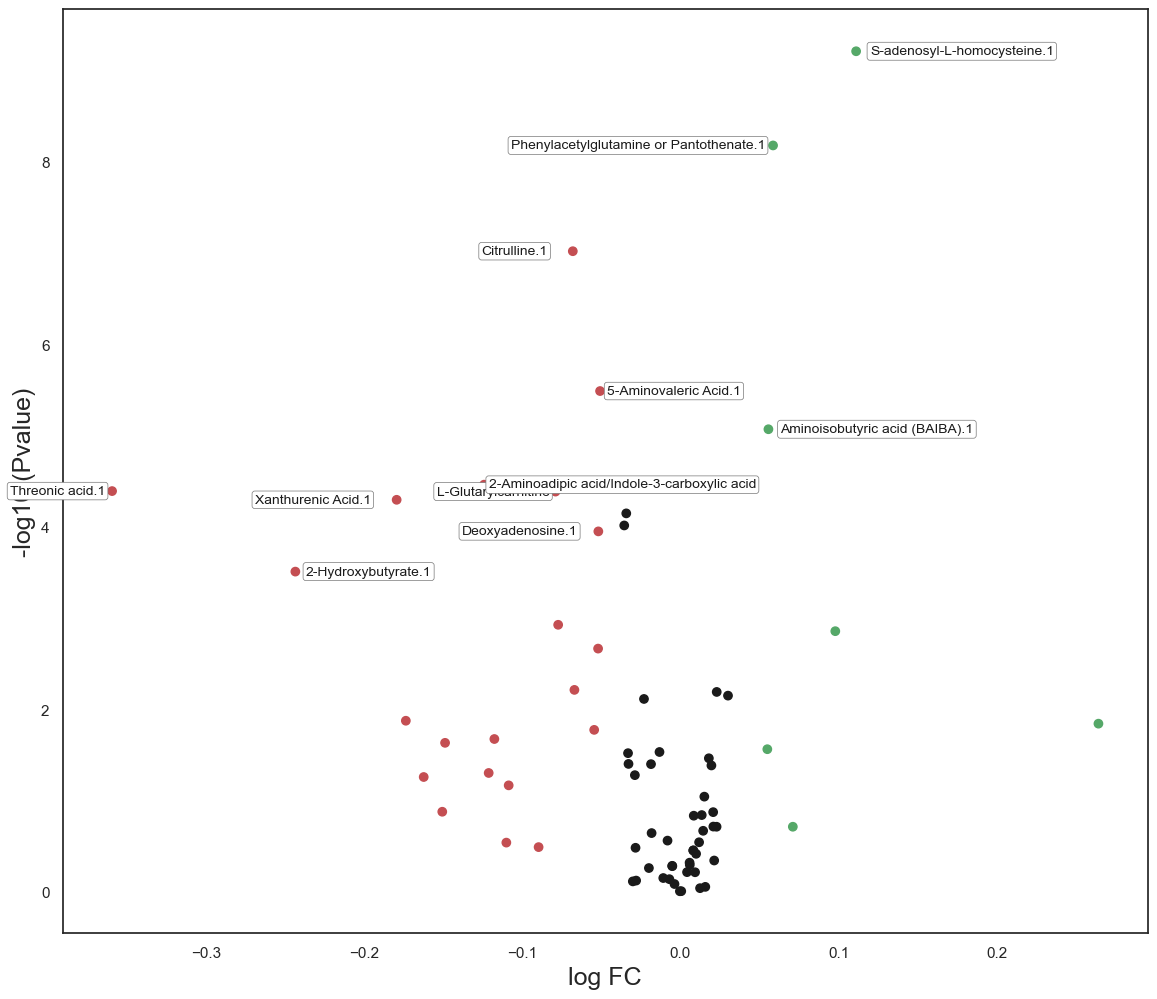

In [56]:
plot_volcano(results_all,fc_threshold=0.05, pvalue_threshold=3)

## Analysis 30 vs 60

In [57]:
factor = 'PND'
results_all = []
for m in metabolites_list:
    data_metabolite = data[data['Metabolite'] == m]
    if data_metabolite[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_metabolite[factor].unique(),2):
            a = data_metabolite[data_metabolite[factor] == c[0]]['log_scaled_area'].values
            b = data_metabolite[data_metabolite[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([m, fc, pvalue, c[0], c[1]])

colnames = ['metabolite', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','pnd_treatment.csv'))

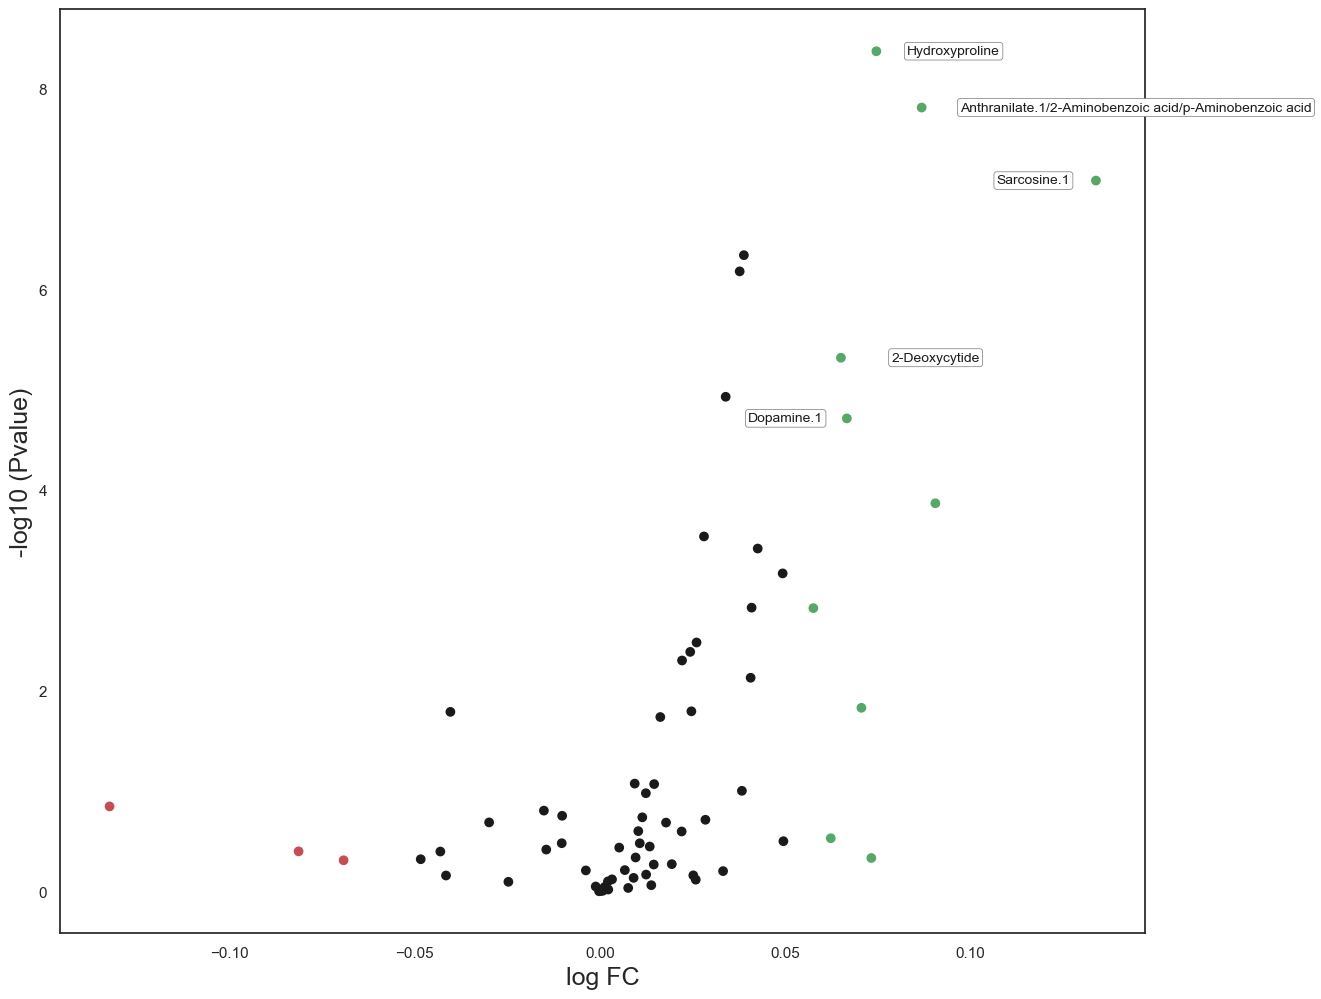

In [58]:
plot_volcano(results_all,fc_threshold=0.05, pvalue_threshold=4)

## Analysis male vs female

In [61]:
factor = 'Sex'
results_all = []
for m in metabolites_list:
    data_metabolite = data[data['Metabolite'] == m]
    if data_metabolite[factor].unique().size > 1: # Some lipids are not found in both classes
        for c in itertools.combinations(data_metabolite[factor].unique(),2):
            a = data_metabolite[data_metabolite[factor] == c[0]]['log_scaled_area'].values
            b = data_metabolite[data_metabolite[factor] == c[1]]['log_scaled_area'].values
            pvalue = ttest_ind(a,b)[1]
            fc = np.mean(a)/np.mean(b)
            results_all.append([m, fc, pvalue, c[0], c[1]])

colnames = ['metabolite', 'fc', 'p', factor+'1', factor+'2']
results_all = pd.DataFrame(data=results_all, columns= colnames)
results_all.head()

results_all.to_csv(os.path.join('results','sex_treatment.csv'))

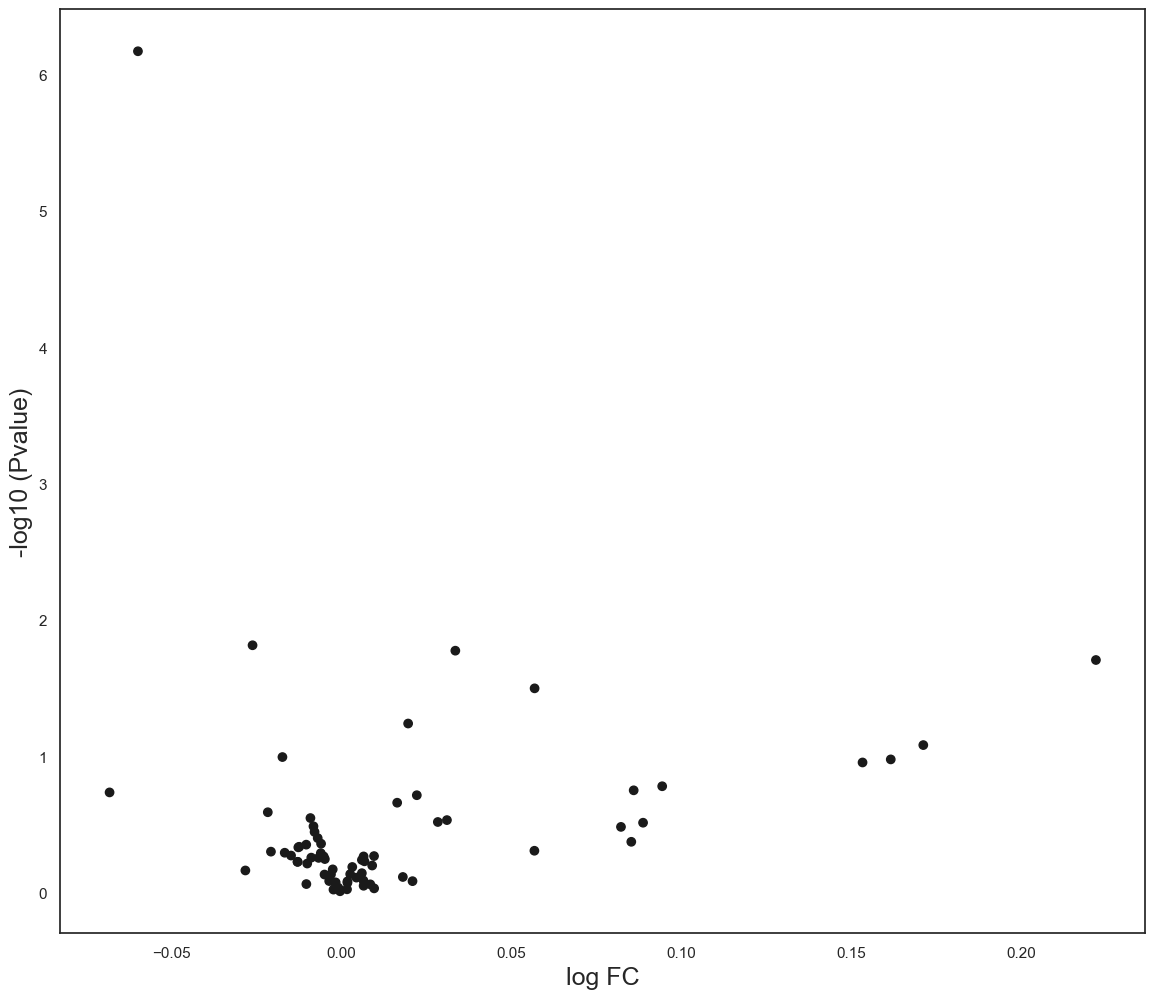

In [62]:
plot_volcano(results_all,fc_threshold=0.3, pvalue_threshold=2)